# ML Models

In [44]:
import os
os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds(42)

## Data Split 

In [45]:
# Read in our pre-processed data sets for each site
site_1 = pd.read_pickle("utilization_data_site1.pkl")
site_2 = pd.read_pickle("utilization_data_site2.pkl")

In [46]:
# Separate target and predictive features
site_1_X = site_1.drop(columns = "utilization")
site_1_y = site_1["utilization"]
site_2_X = site_2.drop(columns = "utilization")
site_2_y = site_2["utilization"]

In [47]:
# Split data into train, test, validation 60/20/20
site_1_X_train, site_1_X_test, site_1_y_train, site_1_y_test = train_test_split(site_1_X, site_1_y, test_size= 0.4, random_state=42)
site_2_X_train, site_2_X_test, site_2_y_train, site_2_y_test = train_test_split(site_2_X, site_2_y, test_size= 0.4, random_state=42)

site_1_X_test, site_1_X_val, site_1_y_test, site_1_y_val = train_test_split(site_1_X_test, site_1_y_test, test_size=0.5, random_state=42)
site_2_X_test, site_2_X_val, site_2_y_test, site_2_y_val = train_test_split(site_2_X_test, site_2_y_test, test_size=0.5, random_state=42)

In [48]:
# Scale data using MinMaxScaler from sklearn
site_1_scaler = MinMaxScaler()
site_2_scaler = MinMaxScaler()

site_1_scaler.fit(site_1_X_train)
site_2_scaler.fit(site_2_X_train)

site_1_X_train = site_1_scaler.fit_transform(site_1_X_train)
site_1_X_test  = site_1_scaler.transform(site_1_X_test)
site_1_X_val  = site_1_scaler.transform(site_1_X_val)


site_2_X_train = site_2_scaler.fit_transform(site_2_X_train)
site_2_X_test  = site_2_scaler.transform(site_2_X_test)
site_2_X_val  = site_2_scaler.transform(site_2_X_val)

## Polynomial Regression

First let us establish a baseline performance for a polynomial model. We consider polynomial degrees in the range of 1 to 14 and display the key metric performances per degree.

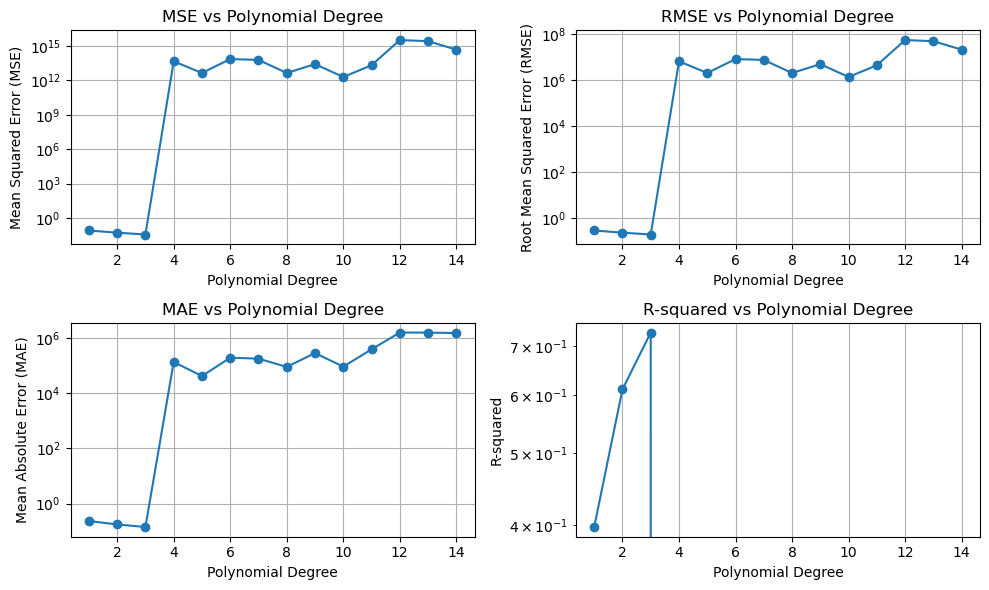

In [7]:
#Polynomial Regression without regularization

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ  
degrees = np.arange(1, 15)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

#iterate over degrees list to calculate the different metrics for each polynomial degree using a polynomial regression
for degree in degrees:

    #create polynomial features for the training set and validation set
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)

    #create object for linear regression and train the model
    model = LinearRegression()
    model.fit(site_1_X_train_poly, site_1_y_train)

    #use model to predict for the validation data
    y_pred = model.predict(site_1_X_val_poly)

    #calculate performance metrics
    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)

    #append calculated values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker="o")
plt.yscale("log")
plt.title("MSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker="o")
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker="o")
plt.yscale("log")
plt.title("MAE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker="o")
plt.yscale("log")
plt.title("R-squared vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.grid(True)

plt.tight_layout()
plt.show()

The metrics are not satisfactory. Especially the the r-squared metric shows that already with degree 5, the model does not represent a good fit to the data whatsoever. Similar results can be seen within the other visualizations. We shall try to utilize regularization to achieve better results


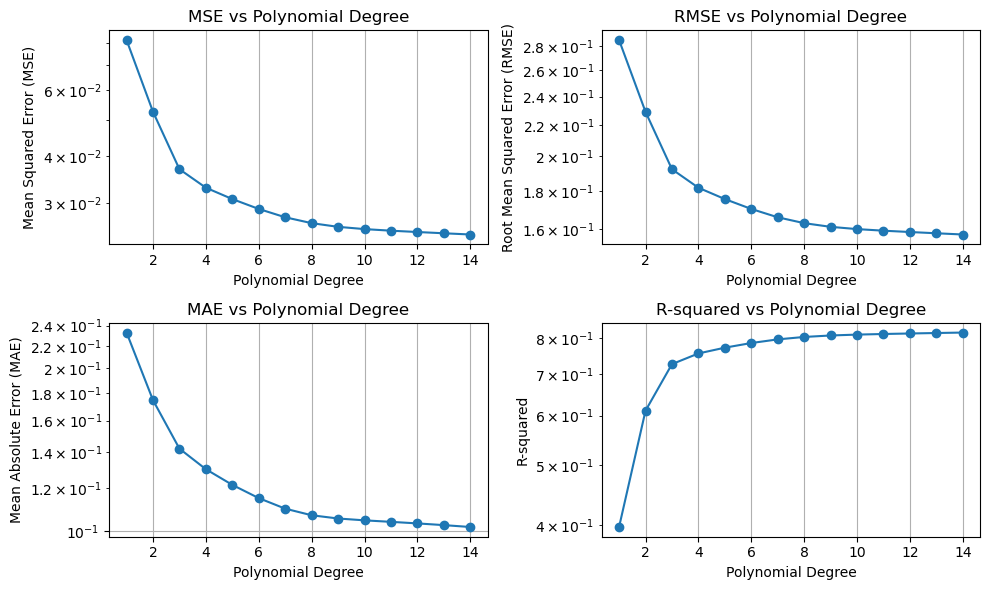

MSE für degree=6: 0.08130702996064912


In [8]:
#Polynomial Regression with L2 regularization

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

#iterate over degrees list to calculate the different metrics for each polynomial degree using a polynomial regression and apply regularization
for degree in degrees:

    #create polynomial features for the training set and validation set
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)

    #create ridge object for the regularized polynomial regression and train the model
    model = Ridge(alpha = 0.25)
    model.fit(site_1_X_train_poly, site_1_y_train)

    #use model to predict for the validation data
    y_pred = model.predict(site_1_X_val_poly)

    #calculate performance metrics
    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)
    
    #append calculated values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker="o")
plt.yscale("log")
plt.title("MSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker="o")
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker="o")
plt.yscale("log")
plt.title("MAE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker="o")
plt.yscale("log")
plt.title("R-squared vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.grid(True)

plt.tight_layout()
plt.show()

The results are far better than without any regularization. The graphs show that with increasing polynomial degree the key metrics improve but stagnate at around the 6th degree.

As an additional hyperparameter, let us also consider the amount of regularizaion (alpha) we apply to our model.

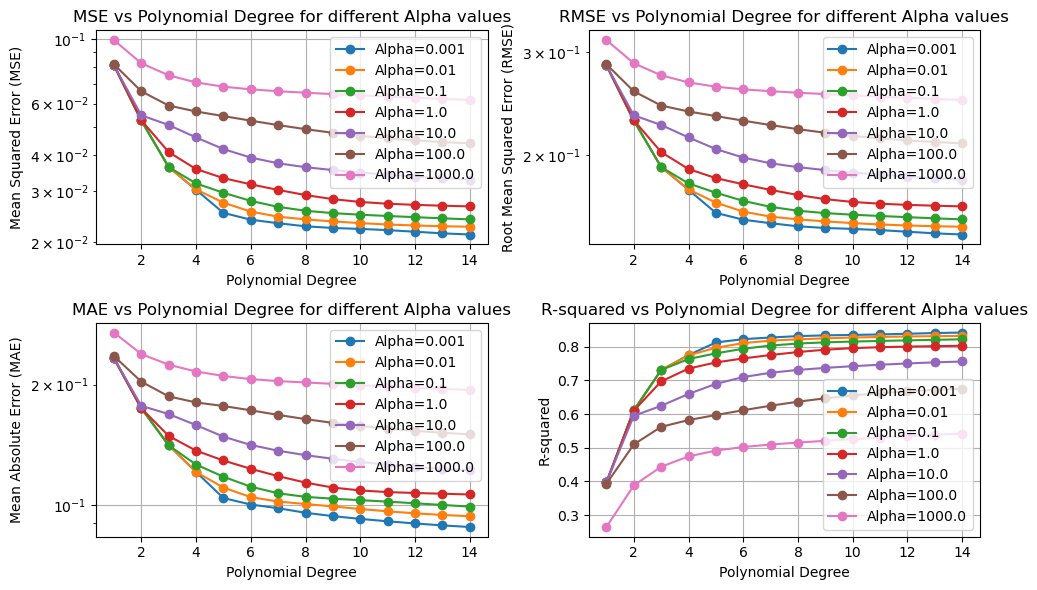

MSE für degree=6 und Alpha=0.001: 0.02390449617019413
MSE für degree=6 und Alpha=0.01: 0.025487598927800913
MSE für degree=6 und Alpha=0.1: 0.027746973651425838
MSE für degree=6 und Alpha=1.0: 0.03163545717458862
MSE für degree=6 und Alpha=10.0: 0.03910170416983105
MSE für degree=6 und Alpha=100.0: 0.052385791766397315
MSE für degree=6 und Alpha=1000.0: 0.0671269107203609


In [9]:
#Polynomial Regression with L2-regularization and different alpha values

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

#iterate over degrees list and alpha values to calculate the different metrics for each combination of polynomial and
#alpha degree using a polynomial regression and apply regularization
for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):

        #create polynomial features for the training set and validation set
        poly_features = PolynomialFeatures(degree=degree)
        site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
        site_1_X_val_poly = poly_features.transform(site_1_X_val)

        #create ridge object for the regularized polynomial regression and train the model
        model = Ridge(alpha=alpha)
        model.fit(site_1_X_train_poly, site_1_y_train)

        #use model to predict for the validation data
        y_pred = model.predict(site_1_X_val_poly)

        #calculate performance metrics
        mse = mean_squared_error(site_1_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_1_y_val, y_pred)
        r2 = r2_score(site_1_y_val, y_pred)

        #append calculated values to lists
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MAE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f"Alpha={alpha}")
plt.title("R-squared vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

As we can see (at least in the first 14 instances) the benchmarks for the polynomial regression improve with higher polynomial degrees. However, we do not want to risk any overfitting, therefore, we will say that a polynomial degree of 6 is sufficient for our model.

Furthermore, lower alpha values for the ridge regression also improve the outcomes for the benchmarks. Choosing alpha as too low, however, increases the risk of overfitting to the training set and results in worse generalization. Thus, we will choose an alpha of 0.11.

Now, let us also look at the public site and train an analog polnyomial model.

In [ ]:
#Polynomial Regression with L2-regularization and different alpha values

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

#iterate over degrees list and alpha values to calculate the different metrics for each combination of polynomial and
#alpha degree using a polynomial regression and apply regularization
for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):

        #create polynomial features for the training set and validation set
        poly_features = PolynomialFeatures(degree=degree)
        site_2_X_train_poly = poly_features.fit_transform(site_2_X_train)
        site_2_X_val_poly = poly_features.transform(site_2_X_val)

        #create ridge object for the regularized polynomial regression and train the model
        model = Ridge(alpha=alpha)
        model.fit(site_2_X_train_poly, site_2_y_train)

        #use model to predict for the validation data
        y_pred = model.predict(site_2_X_val_poly)

        #calculate performance metrics
        mse = mean_squared_error(site_2_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_2_y_val, y_pred)
        r2 = r2_score(site_2_y_val, y_pred)

        #append calculated values to lists
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MAE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f"Alpha={alpha}")
plt.title("R-squared vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Decision Tree

Our next approach used to create a predictive model, we opted for a decision tree and a corresponding decision tree regression. In addition, GridSearch supports the search and selection of the best possible values for the hyperparameters. We decided to stick to the following choice of hyperparameters to control both the complexity and predictive power of the decision tree:
- "max_depth": Defines maximal allowed depth of the tree.
- "min_samples_split": Defines minimal requirement of samples to split a node. To prevent the Decision to split up too much in smaller subsets due to noise in data.  
- "min_samples_leaf": Defines the minimum number of samples that must be in a leaf node. If any resulting leaf node would have fewer samples than "min_samples_leaf" after a split, the split is not performed and the node becomes a leaf node directly.
- "max_features": Specifies the maximum number of features to consider when searching for the best split at each node. 

Best Hyperparameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 25, 'min_samples_split': 75}


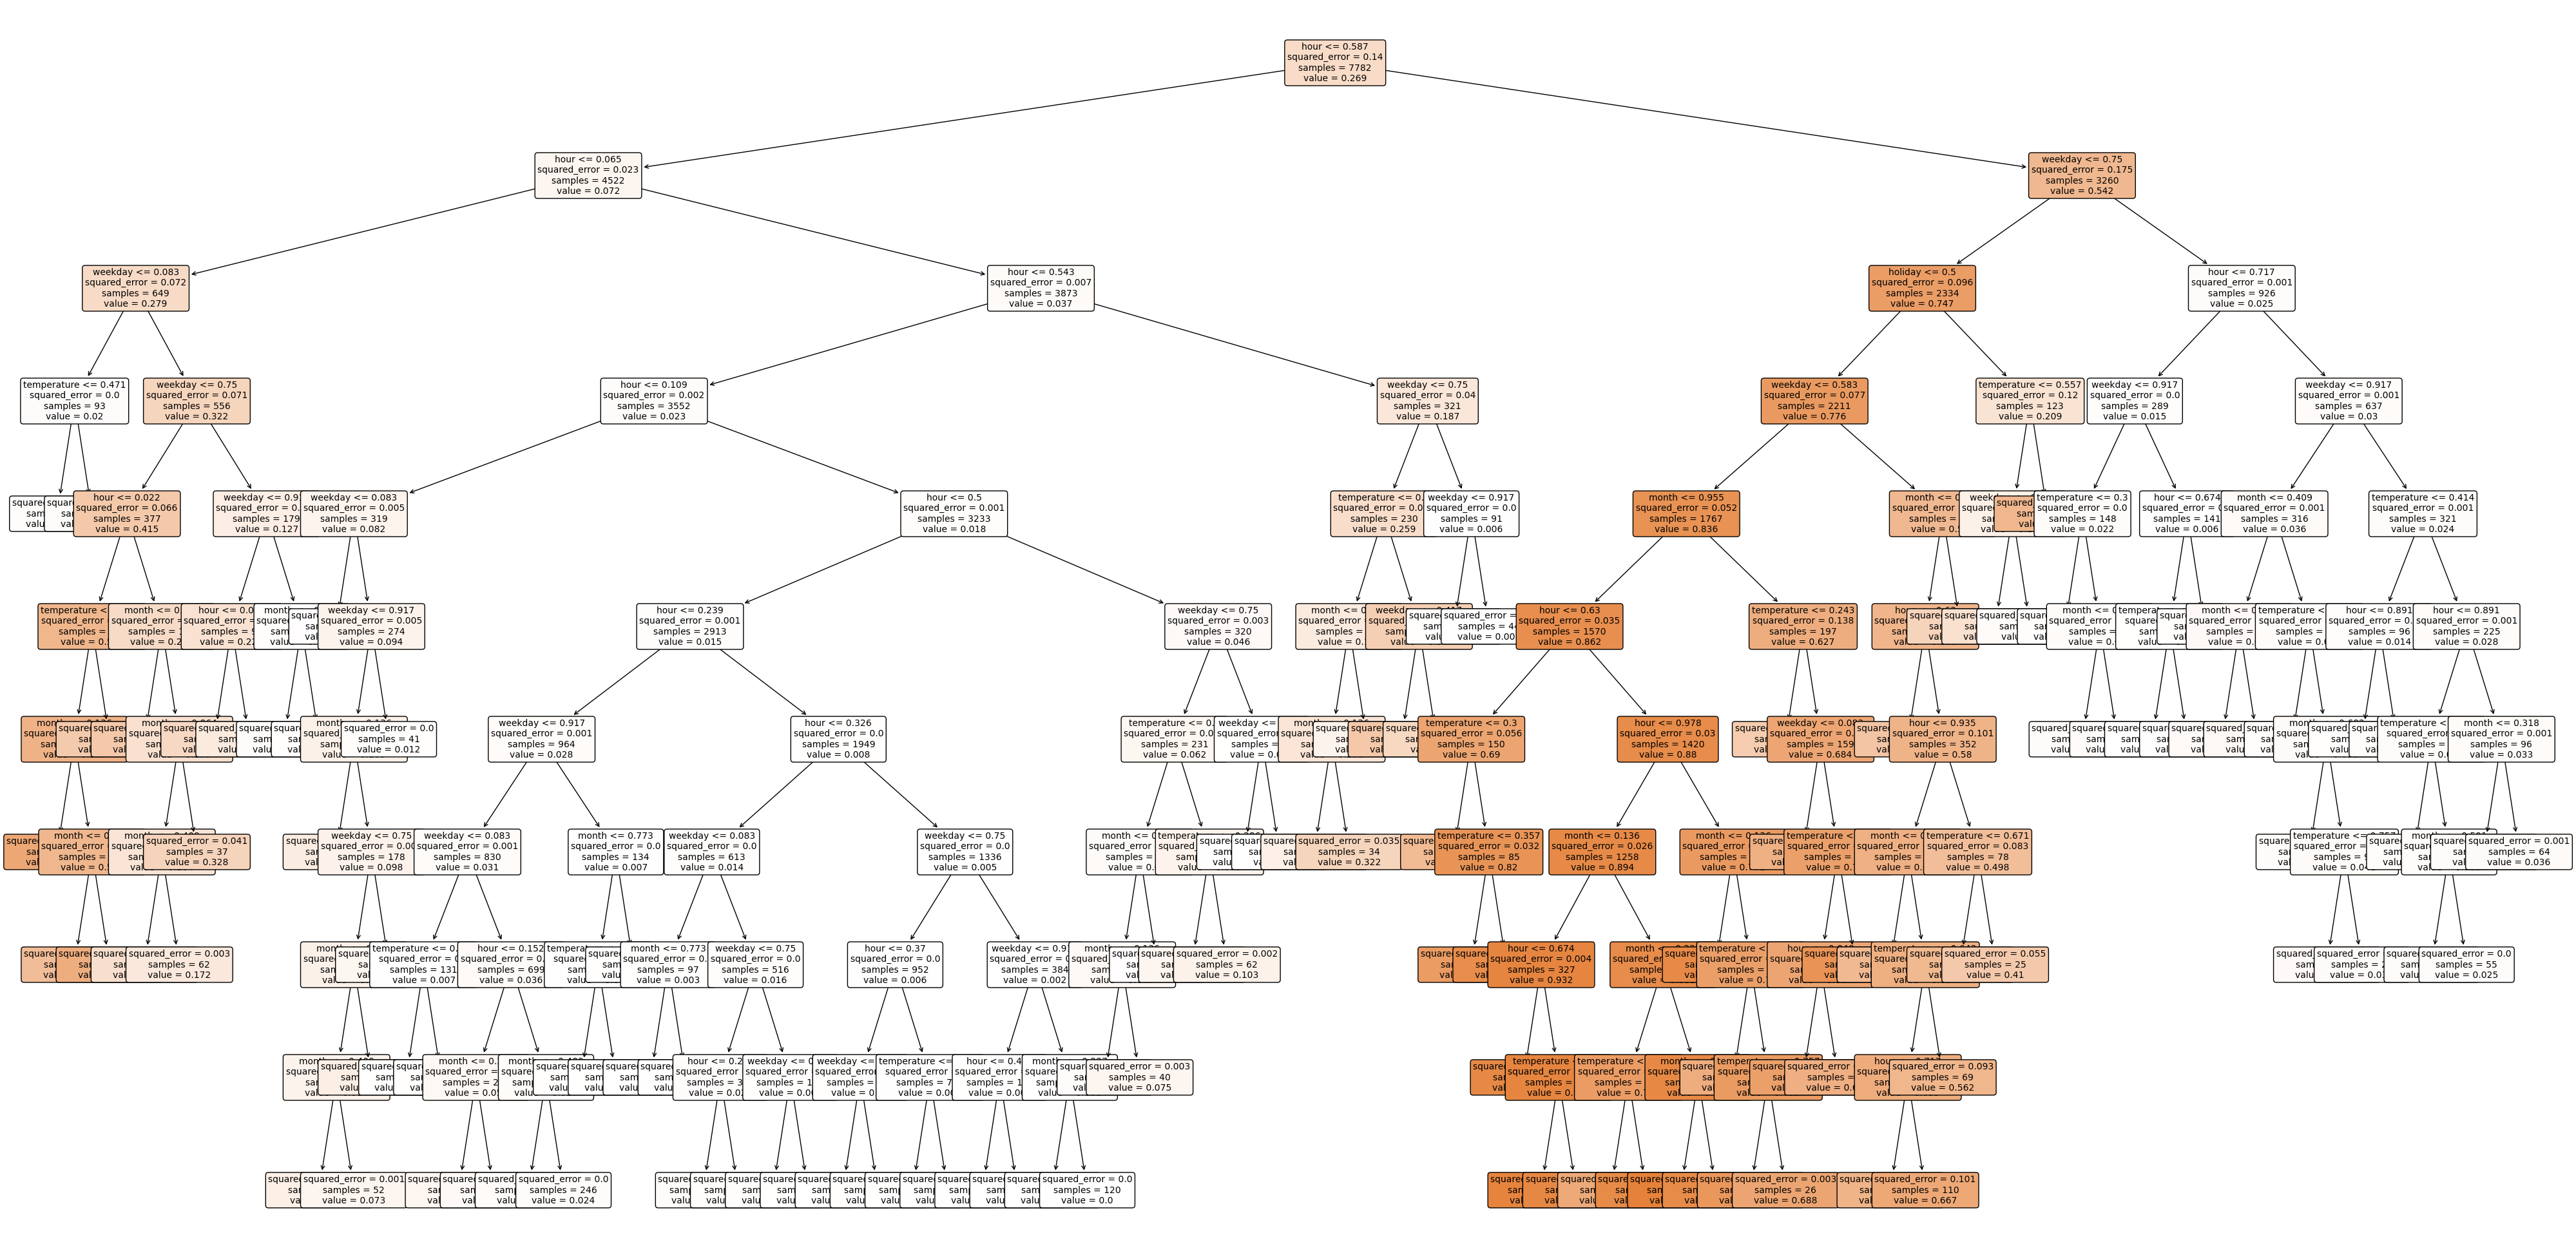

Number of Nodes: 213
Number of Leaves: 107
MSE on Validation Set: 0.01750478184024303
RMSE on Validation Set: 0.13230563797602515
MAE on Validation Set: 0.06499996906397364
R2 on Validation Set: 0.8702272540245558


In [49]:
# Define the Decision Tree Regression model
dtree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for GridSearch to find "best possible" Decision Tree
param_grid = {
    "max_depth": [5, 7, 10],  
    "min_samples_split": [75, 100, 150],  
    "min_samples_leaf": [15, 25, 35],
    "max_features": [0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(dtree_model, param_grid, scoring="neg_mean_squared_error", cv=5)

# Train the model via the use of GridSearch on train data set
grid_search.fit(site_1_X_train, site_1_y_train)

# Save the selection of the best hyperparameters and trained model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Display selection of best hyperparameters
print("Best Hyperparameters:", best_params)

# Plot the best Decision Tree
plt.figure(figsize=(50, 25))
plot_tree(best_model, filled=True, feature_names=site_1_X.columns, rounded=True, fontsize=10)
plt.show()

# Save the number of nodes and leaves of the best Decision Tree
num_nodes = best_model.tree_.node_count
num_leaves = best_model.get_n_leaves()

# Evaluate performance of our model via validation set; could be used for further adjustments of the hyperparameters values or hyperparameter selection itself 
y_pred = best_model.predict(site_1_X_val)
mse = mean_squared_error(site_1_y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(site_1_y_val, y_pred)
r2 = r2_score(site_1_y_val, y_pred)

# Display performance measures
print("Number of Nodes:", num_nodes)
print("Number of Leaves:", num_leaves)
print("MSE on Validation Set:", mse)
print("RMSE on Validation Set:", rmse)
print("MAE on Validation Set:", mae)
print("R2 on Validation Set:", r2)

Best Hyperparameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 50, 'min_samples_split': 75}


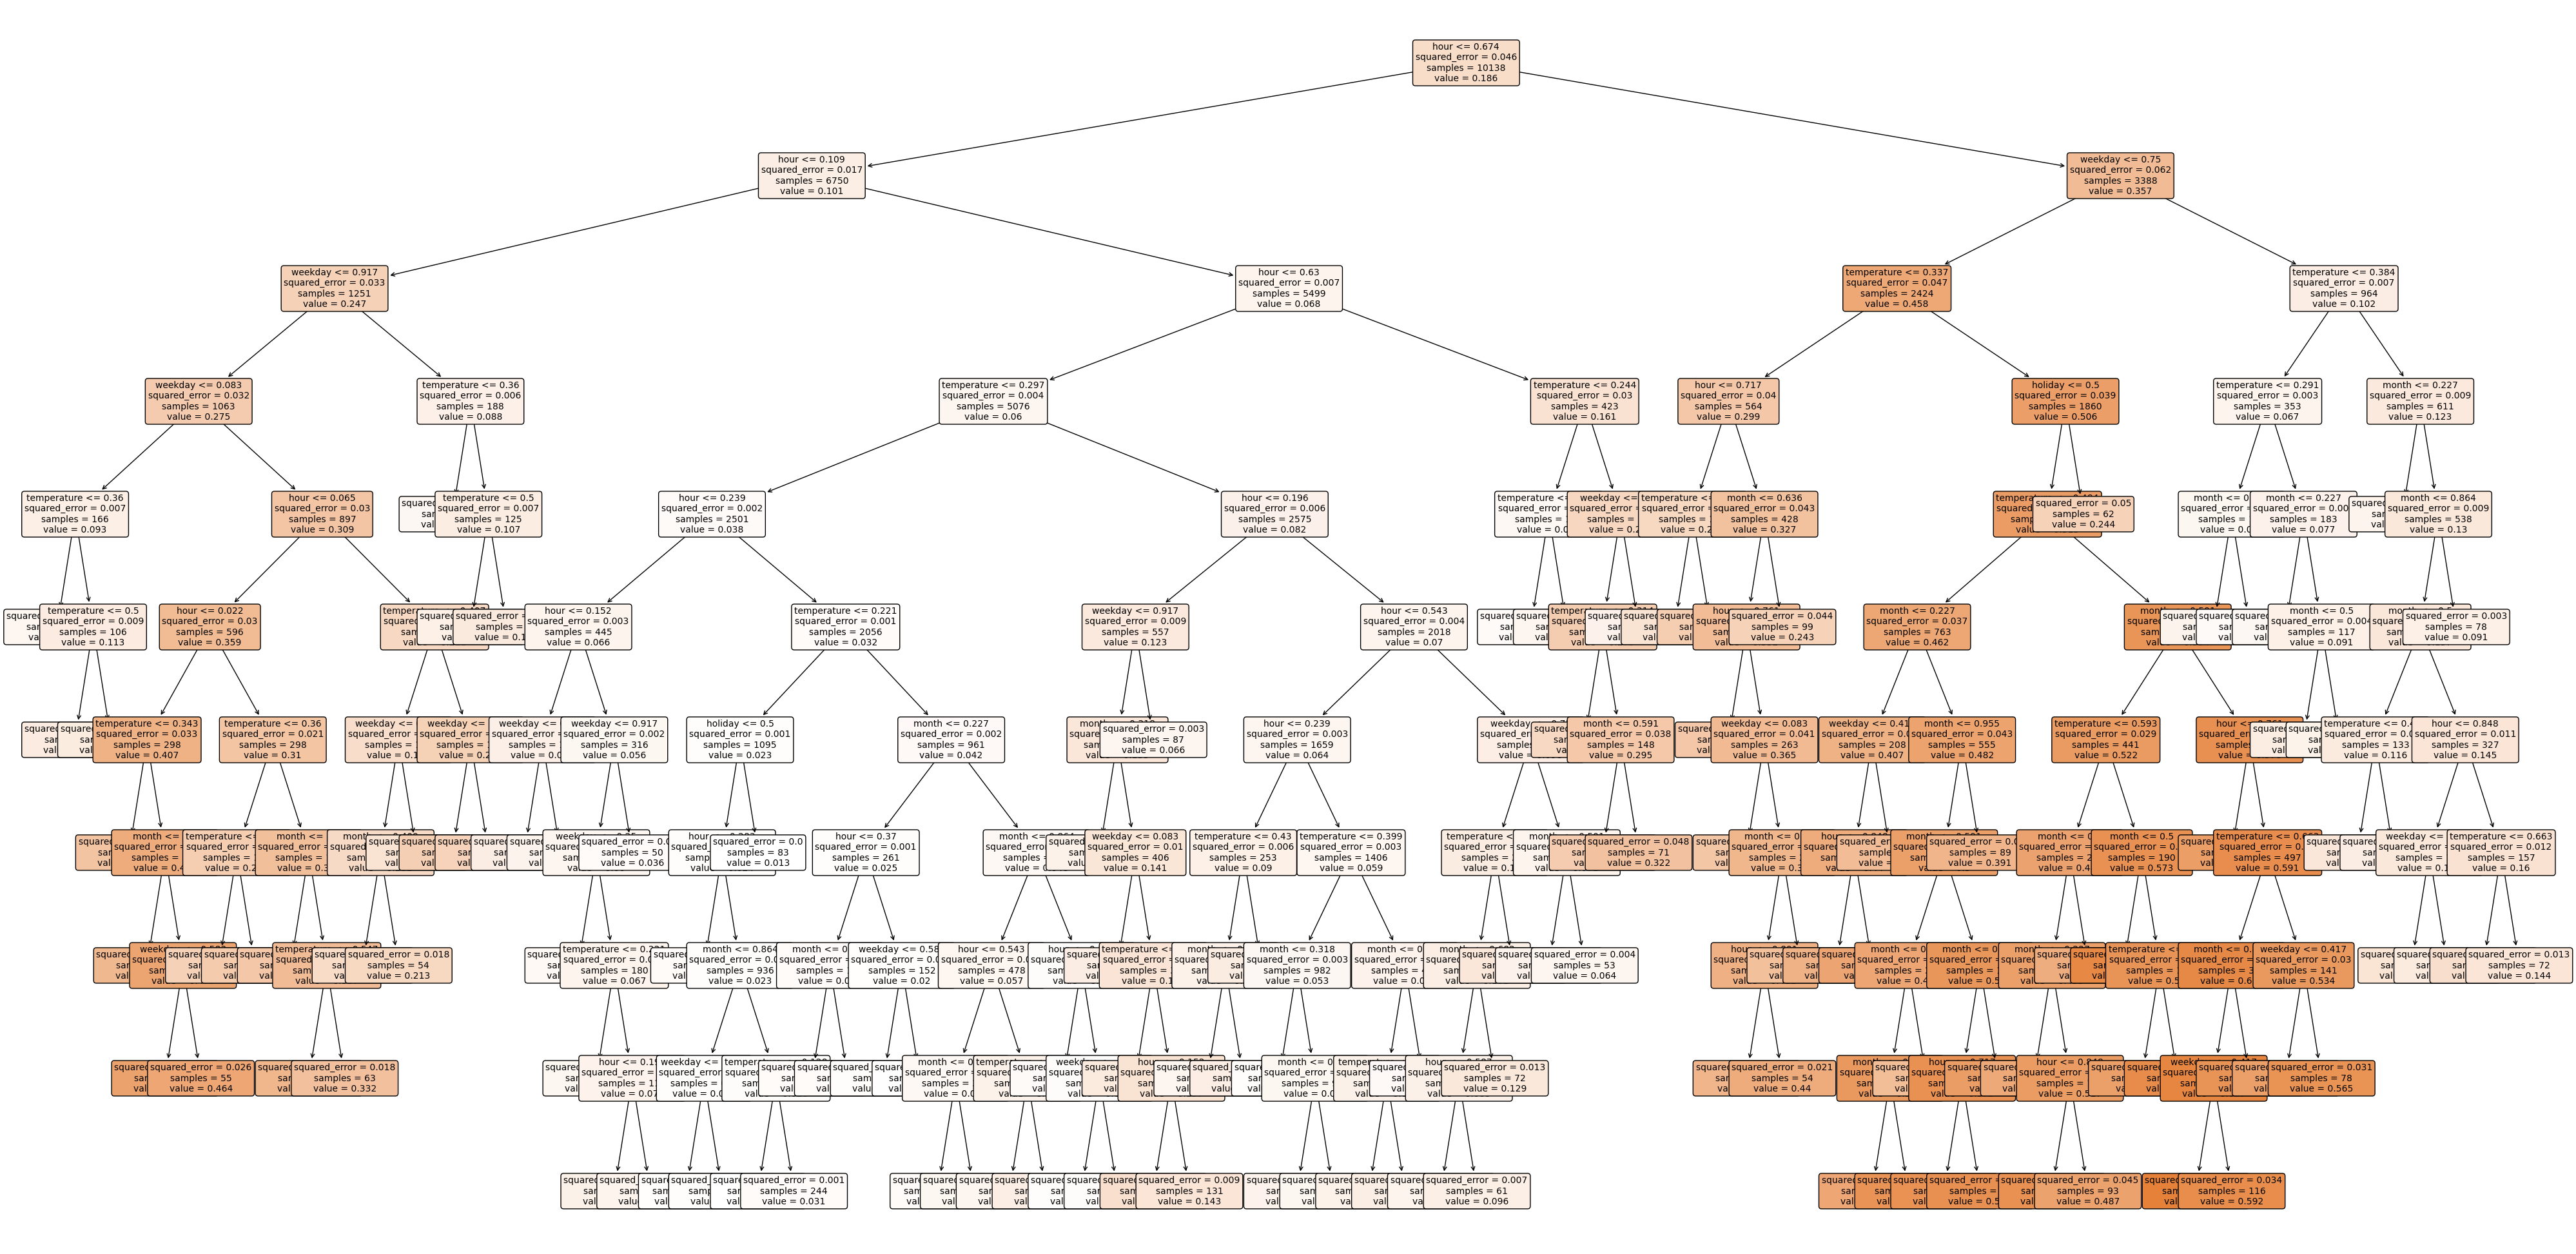

Number of Nodes: 231
Number of Leaves: 116
MSE: 0.011984300296701327
Root Mean Squared Error on Validation Set: 0.10947282903397229
MAE: 0.07774201396691213
R2: 0.7274476286673948


In [13]:
# Define the Decision Tree Regression model
dtree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for GridSearch to find "best possible" Decision Tree
param_grid = {
    "max_depth": [5, 7, 10], 
    "min_samples_split": [75, 100, 150, 250, 500], 
    "min_samples_leaf": [50, 100, 150, 250, 500], 
    "max_features": [0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(dtree_model, param_grid, scoring="neg_mean_squared_error", cv=5)

# Train the model via the use of GridSearch on train data set
grid_search.fit(site_2_X_train, site_2_y_train)

# Save the selection of the best hyperparameters and trained model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Display selection of best hyperparameters
print("Best Hyperparameters:", best_params)

# Plot the best Decision Tree
plt.figure(figsize=(50, 25))
plot_tree(best_model, filled=True, feature_names=site_2_X.columns, rounded=True, fontsize=10)
plt.show()

# Save the number of nodes and leaves of the best Decision Tree
num_nodes = best_model.tree_.node_count
num_leaves = best_model.get_n_leaves()

# Evaluate performance of our model via validation set; could be used for further adjustments of the hyperparameters values or hyperparameter selection itself 
y_pred = best_model.predict(site_2_X_val)
mse = mean_squared_error(site_2_y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(site_2_y_val, y_pred)
r2 = r2_score(site_2_y_val, y_pred)

# Display performance measures
print("Number of Nodes:", num_nodes)
print("Number of Leaves:", num_leaves)
print("MSE on Validation Set:", mse)
print("RMSE on Validation Set:", rmse)
print("MAE on Validation Set:", mae)
print("R2 on Validation Set:", r2)

## Neural Network

In [14]:
tf.random.set_seed(42)
# Build a relatively simple neural net with a few layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_1 = model_1.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 100)

Epoch 1/100
244/244 [==============================] - 2s 3ms/step - loss: 0.0632 - mae: 0.1757 - val_loss: 0.0485 - val_mae: 0.1492
Epoch 2/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0446 - mae: 0.1381 - val_loss: 0.0377 - val_mae: 0.1237
Epoch 3/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0327 - mae: 0.1114 - val_loss: 0.0274 - val_mae: 0.0979
Epoch 4/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0258 - mae: 0.0958 - val_loss: 0.0234 - val_mae: 0.0832
Epoch 5/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0232 - mae: 0.0869 - val_loss: 0.0252 - val_mae: 0.0842
Epoch 6/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0232 - mae: 0.0876 - val_loss: 0.0216 - val_mae: 0.0872
Epoch 7/100
244/244 [==============================] - 0s 2ms/step - loss: 0.0215 - mae: 0.0823 - val_loss: 0.0220 - val_mae: 0.0881
Epoch 8/100
244/244 [==============================] - 0s 2ms/step - 

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

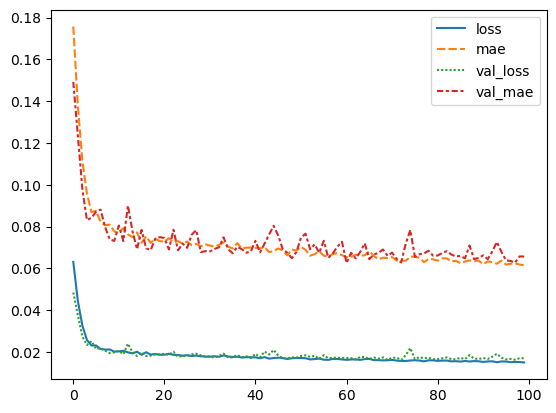

In [15]:
sns.lineplot(history_model_1.history)

While the decrease of loss levels out relatively quick after about 10 epochs, there is still a slight downward trend recognizable. Because the model complexity and the amount of data is rather low, epochs don't take very long to run. We will use an early stopping callback to let the training run for a high amount of epochs, until there is a divergence between training and validation loss, which would indicate overfitting.

In [16]:
# Early stopping callback that monitors validation loss and stops training after it stops decreasing for more than 25 epochs. Restores the model to the best weights it achieved on val loss afterwards.
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, restore_best_weights = True)

# Build a relatively simple neural net with a few layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_2 = model_2.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 10000,
                    callbacks = [early_stop])

Epoch 1/10000
244/244 [==============================] - 1s 3ms/step - loss: 0.0647 - mae: 0.1811 - val_loss: 0.0496 - val_mae: 0.1520
Epoch 2/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0446 - mae: 0.1400 - val_loss: 0.0365 - val_mae: 0.1245
Epoch 3/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0349 - mae: 0.1187 - val_loss: 0.0289 - val_mae: 0.1079
Epoch 4/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0290 - mae: 0.1068 - val_loss: 0.0245 - val_mae: 0.0929
Epoch 5/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0255 - mae: 0.0983 - val_loss: 0.0291 - val_mae: 0.1069
Epoch 6/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0244 - mae: 0.0956 - val_loss: 0.0269 - val_mae: 0.1209
Epoch 7/10000
244/244 [==============================] - 0s 2ms/step - loss: 0.0222 - mae: 0.0884 - val_loss: 0.0226 - val_mae: 0.0882
Epoch 8/10000
244/244 [==============================] 

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

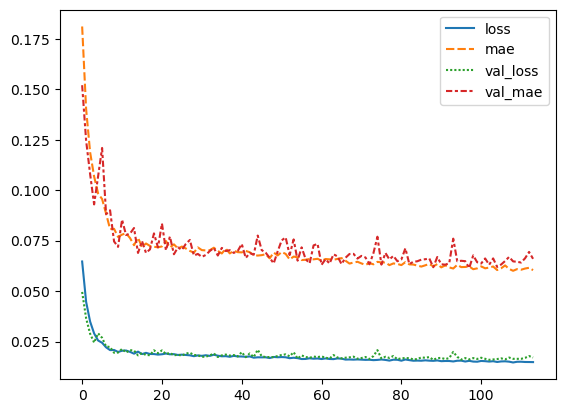

In [17]:
sns.lineplot(history_model_2.history)

Training stops after 130 epochs. With the early stopping, this means that validation loss stops decreasing after around 100 epochs. With there still being a downward trend in the training loss discernible at the end, this indicates that the model starts over-fitting to the training data at the end. One way to counter this in the model architecture is by using dropout layers in the first few layers. We'll add two drop-out layers in the beginning, with a drop-out ratio of 10% and increase the number epochs to 300.

In [18]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3 = model_3.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0735 - mae: 0.1949 - val_loss: 0.0526 - val_mae: 0.1571
Epoch 2/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0511 - mae: 0.1528 - val_loss: 0.0402 - val_mae: 0.1289
Epoch 3/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0420 - mae: 0.1326 - val_loss: 0.0340 - val_mae: 0.1178
Epoch 4/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0352 - mae: 0.1189 - val_loss: 0.0279 - val_mae: 0.0962
Epoch 5/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0294 - mae: 0.1045 - val_loss: 0.0240 - val_mae: 0.0888
Epoch 6/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0276 - mae: 0.0984 - val_loss: 0.0247 - val_mae: 0.0836
Epoch 7/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0256 - mae: 0.0931 - val_loss: 0.0230 - val_mae: 0.0823
Epoch 8/300
244/244 [==============================] - 0s 2ms/step - 

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

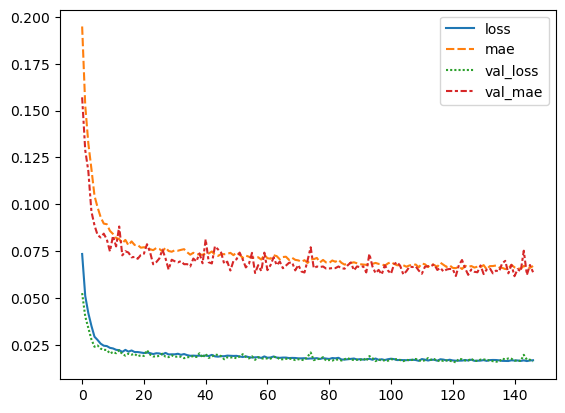

In [19]:
sns.lineplot(history_model_3.history)

In [20]:
model_3_site_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3_site_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3_site_2 = model_3_site_2.fit(site_2_X_train,
                    site_2_y_train,
                    validation_data = (site_2_X_val,site_2_y_val),
                    epochs = 150)

Epoch 1/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0265 - mae: 0.1193 - val_loss: 0.0178 - val_mae: 0.0935
Epoch 2/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0197 - mae: 0.0982 - val_loss: 0.0159 - val_mae: 0.0891
Epoch 3/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0185 - mae: 0.0944 - val_loss: 0.0157 - val_mae: 0.0896
Epoch 4/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0169 - mae: 0.0898 - val_loss: 0.0144 - val_mae: 0.0832
Epoch 5/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0161 - mae: 0.0880 - val_loss: 0.0140 - val_mae: 0.0814
Epoch 6/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0153 - mae: 0.0853 - val_loss: 0.0134 - val_mae: 0.0804
Epoch 7/150
317/317 [==============================] - 1s 2ms/step - loss: 0.0149 - mae: 0.0845 - val_loss: 0.0142 - val_mae: 0.0807
Epoch 8/150
317/317 [==============================] - 1s 2ms/step - 

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

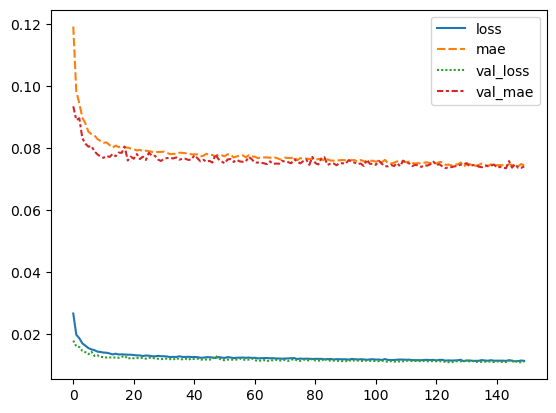

In [21]:
sns.lineplot(history_model_3_site_2.history)

While not big, training a model of the same architecture on site 2 training data, yields a small difference in final MAE. A possible for this explanation could be the difference between the two sites. Site 1, being the private charging site at a company, will probably have charging events that look more alike than site 2, the public charging site. As a final step, let's try scaling up the model architecture, using more layers with a higher amount of neurons per layer.

In [22]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_4.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_4 = model_4.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 4s 11ms/step - loss: 0.0559 - mae: 0.1544 - val_loss: 0.0372 - val_mae: 0.1269
Epoch 2/300
244/244 [==============================] - 2s 10ms/step - loss: 0.0337 - mae: 0.1074 - val_loss: 0.0253 - val_mae: 0.0840
Epoch 3/300
244/244 [==============================] - 2s 10ms/step - loss: 0.0273 - mae: 0.0925 - val_loss: 0.0229 - val_mae: 0.0763
Epoch 4/300
244/244 [==============================] - 2s 10ms/step - loss: 0.0254 - mae: 0.0875 - val_loss: 0.0215 - val_mae: 0.0815
Epoch 5/300
244/244 [==============================] - 2s 9ms/step - loss: 0.0237 - mae: 0.0841 - val_loss: 0.0200 - val_mae: 0.0726
Epoch 6/300
244/244 [==============================] - 2s 10ms/step - loss: 0.0250 - mae: 0.0866 - val_loss: 0.0208 - val_mae: 0.0770
Epoch 7/300
244/244 [==============================] - 3s 11ms/step - loss: 0.0229 - mae: 0.0812 - val_loss: 0.0227 - val_mae: 0.0870
Epoch 8/300
244/244 [==============================] - 2s 10ms/

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

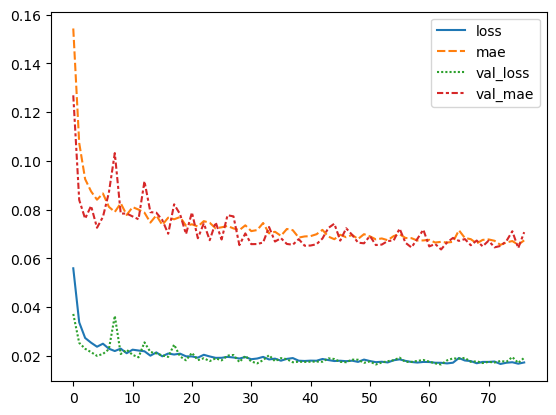

In [23]:
sns.lineplot(history_model_4.history)

The results of this are similar to the simpler architecture of model 3, with a higher complexity, resulting in longer training and inferencing times. While this is not really relevant to our current situation, this could lead to problems when trying to scale the system up. Let's try the opposite, and use an even simpler model.

In [24]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_5.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_5 = model_5.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 2ms/step - loss: 0.1017 - mae: 0.2512 - val_loss: 0.0726 - val_mae: 0.2141
Epoch 2/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0736 - mae: 0.2037 - val_loss: 0.0654 - val_mae: 0.1917
Epoch 3/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.1887 - val_loss: 0.0621 - val_mae: 0.1829
Epoch 4/300
244/244 [==============================] - 0s 2ms/step - loss: 0.0662 - mae: 0.1841 - val_loss: 0.0606 - val_mae: 0.1726
Epoch 5/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0635 - mae: 0.1777 - val_loss: 0.0585 - val_mae: 0.1728
Epoch 6/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1771 - val_loss: 0.0567 - val_mae: 0.1693
Epoch 7/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1719 - val_loss: 0.0551 - val_mae: 0.1662
Epoch 8/300
244/244 [==============================] - 0s 1ms/step - 

C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nils\anaconda3\envs\P310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

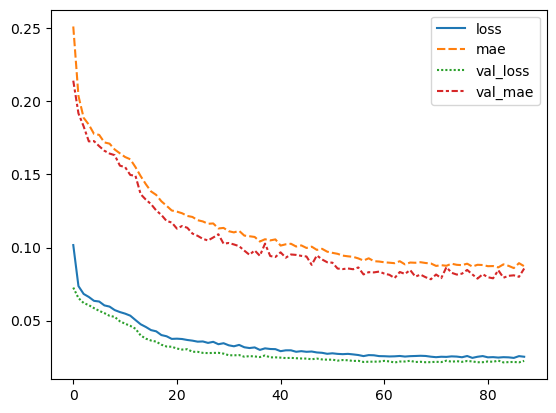

In [25]:
sns.lineplot(history_model_5.history)

The results of this are slightly worse than model 3, with over-fitting creeping in around epoch 90. While further experimentation might yield slightly better results, they are not guaranteed. We will stop here and test the models, both site 1 and site 2, on the testing data to get our final result.

In [26]:
model_3.evaluate(site_1_X_test, site_1_y_test)

82/82 [==============================] - 0s 1ms/step - loss: 0.0170 - mae: 0.0643


[0.016965610906481743, 0.06427256762981415]

In [30]:
site_1_y_pred = model_3.predict(site_1_X_test)
site_2_y_pred = model_3_site_2.predict(site_2_X_test)

site_1_r2 = r2_score(site_1_y_test, site_1_y_pred)
site_2_r2 = r2_score(site_2_y_test, site_2_y_pred)
site_1_r2, site_2_r2

106/106 [==============================] - 0s 895us/step


(0.8809939150542676, 0.7571275995308906)